# **Brain Tumor MRI Image Classification**

## **Project Type**- Classification

## **Contribution** - Individual

## **Name** - Janani Ravi

# **Project Summary** 

# **GitHub Link** - [Click here](https://github.com/Jan2309jr/Brain-Tumor-MRI-Image-Classification.git)

# **Problem Statement**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# **1. Understanding my Dataset**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import matplotlib.cm as cm
from PIL import Image
from collections import defaultdict

## Loading the dataset

In [2]:
#setting paths
base_path="/kaggle/input/brain-tumor-trainingset/Brain-Tumor-Dataset"
train_path=os.path.join(base_path,"train")
test_path=os.path.join(base_path,"test")
valid_path=os.path.join(base_path,"valid")

## Number of categories(tumor types)

In [3]:
def categories(data_path):
    categories = []
    for i in os.listdir(data_path):
        if(os.path.isdir(os.path.join(data_path,i))):
            categories.append(i)
    return categories
print("Brain Tumor Dataset")
print(categories(base_path))
print("Train folder")
print(categories(train_path))

Brain Tumor Dataset
['valid', 'test', 'train']
Train folder
['pituitary', 'no_tumor', 'meningioma', 'glioma']


## First View of dataset

Training set image samples

 pituitary


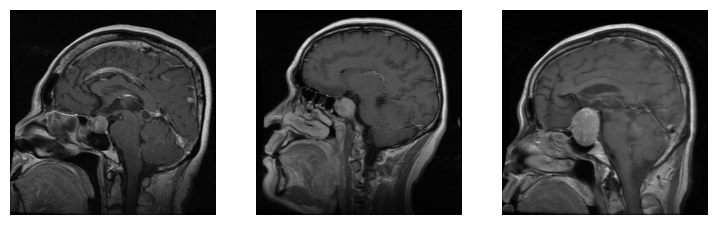


 no_tumor


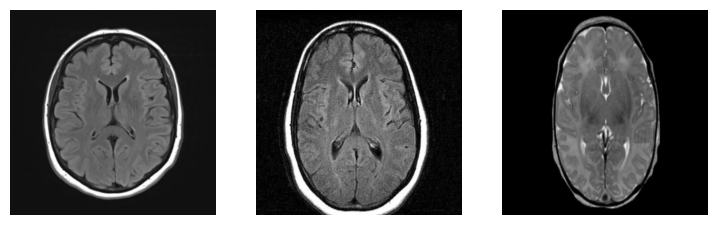


 meningioma


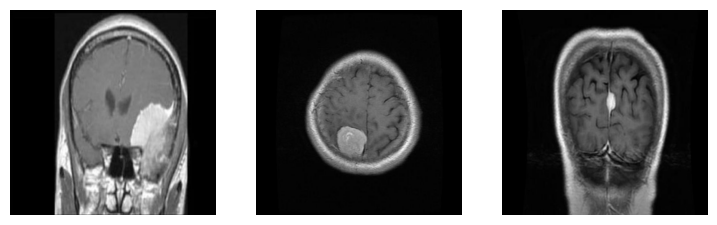


 glioma


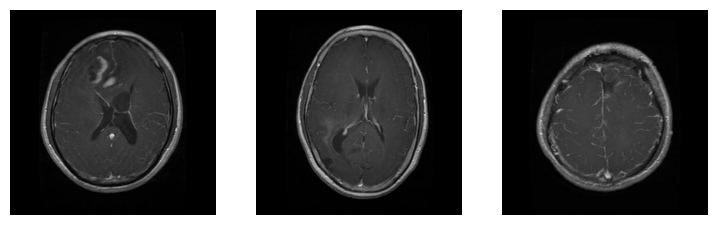

In [4]:
def show_sample_images(data_path,n=3):
    for i in os.listdir(data_path):
        cat_path=os.path.join(data_path,i)
        if(os.path.isdir(cat_path)):
            images=os.listdir(cat_path)[:3]
            plt.figure(figsize=(n*3,3))
            print("\n",i)
            for k,j in enumerate(images):
                img=Image.open(os.path.join(cat_path,j))
                plt.subplot(1,n,k+1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
print("Training set image samples")
show_sample_images(train_path)

## Dataset count in each category

In [5]:
def count_dataset(data_path):
    print(f"The dataset has {len(os.listdir(data_path))} folders: {os.listdir(data_path)} \n")
    print("-----------")
    for i in os.listdir(data_path):
        count_cat=0;
        print(f"{i} folder :-")
        if(os.path.isdir(os.path.join(data_path,i))):
            for j in os.listdir(os.path.join(data_path,i)):
                if(os.path.isdir(os.path.join(data_path,i,j))):
                    count_cat+=1
                    print(f"{j} : {len(os.listdir(os.path.join(data_path,i,j)))}")
        print("-----------")
        

count_dataset(base_path)

The dataset has 3 folders: ['valid', 'test', 'train'] 

-----------
valid folder :-
pituitary : 118
no_tumor : 99
meningioma : 124
glioma : 161
-----------
test folder :-
pituitary : 54
no_tumor : 49
meningioma : 63
glioma : 80
-----------
train folder :-
pituitary : 438
no_tumor : 335
meningioma : 358
glioma : 564
-----------


## Checking class imbalance visually in Training set

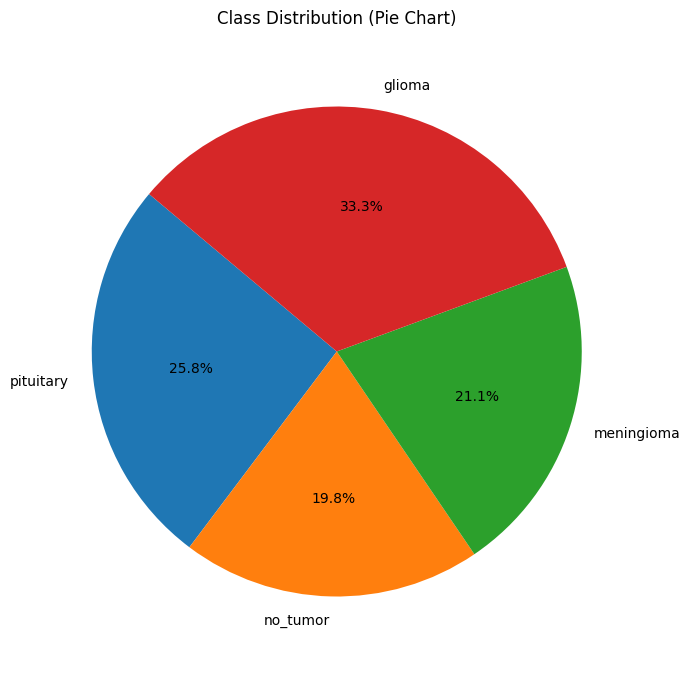

In [6]:
def class_distribution(data_path):
    class_count = {}

    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            class_count[class_name] = len(image_files)

    # Prepare data for pie chart
    labels = [*class_count.keys()]
    sizes = [*class_count.values()]

    # Plot pie chart
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140 )
    plt.title("Class Distribution (Pie Chart)")
    plt.axis('equal')  # Equal aspect ratio makes it a circle
    plt.tight_layout()
    plt.show()
class_distribution(train_path)

## Image resolution consistency


Unique Image Resolutions:
(640, 640): 1695 images


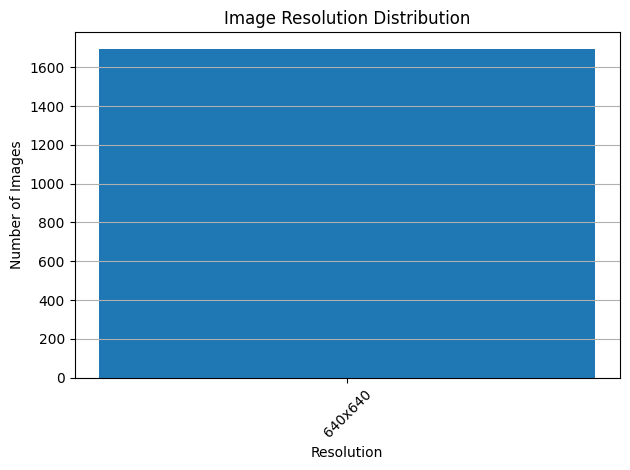

In [7]:
def check_image_resolutions(data_path):
    resolutions = {}

    for folder in os.listdir(data_path):
        path = os.path.join(data_path, folder)
        if not os.path.isdir(path):
            continue

        for file in os.listdir(path):
            try:
                img = Image.open(os.path.join(path, file))
                size = img.size  # (width, height)
                resolutions[size] = resolutions.get(size, 0) + 1
            except:
                print(f"Error reading {file}")

    print("\nUnique Image Resolutions:")
    for res, count in sorted(resolutions.items(), key=lambda x: -x[1]):
        print(f"{res}: {count} images")

    # Plot
    if resolutions:
        labels = [f"{w}x{h}" for (w, h) in resolutions.keys()]
        values = values = [v for v in resolutions.values()]

        plt.bar(labels, values)
        plt.title("Image Resolution Distribution")
        plt.xlabel("Resolution")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
check_image_resolutions(train_path)

## Exploratory Data Analysis

### Univariant Analysis

#### 1. Training Set Class Distribution Bar Graph

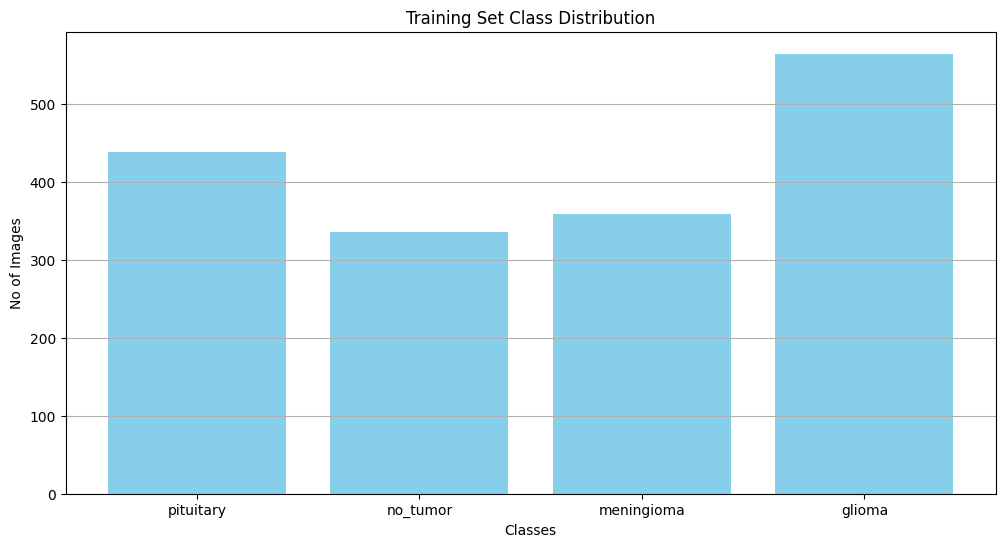

In [8]:
list1=[]
count=[]
for i in os.listdir(train_path):
    if(os.path.isdir(os.path.join(train_path,i))):
        list1.append(i)
        count.append(len(os.listdir(os.path.join(train_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list1,count,color="skyblue")
plt.title("Training Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 2. Test Set Class Distribution Bar Graph

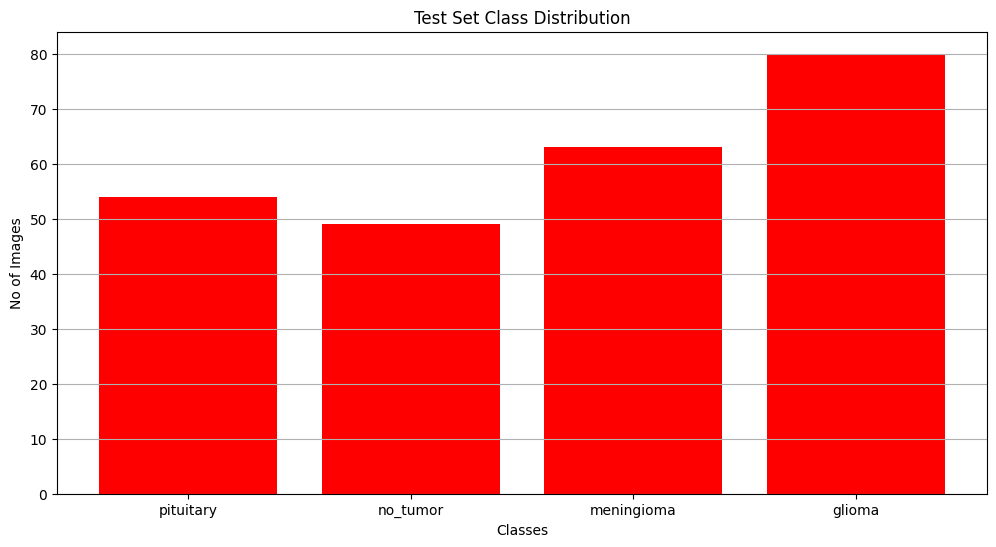

In [9]:
list2=[]
count=[]
for i in os.listdir(test_path):
    if(os.path.isdir(os.path.join(test_path,i))):
        list2.append(i)
        count.append(len(os.listdir(os.path.join(test_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list2,count,color="red")
plt.title("Test Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 3. Valid Set Class Distribution Bar Graph

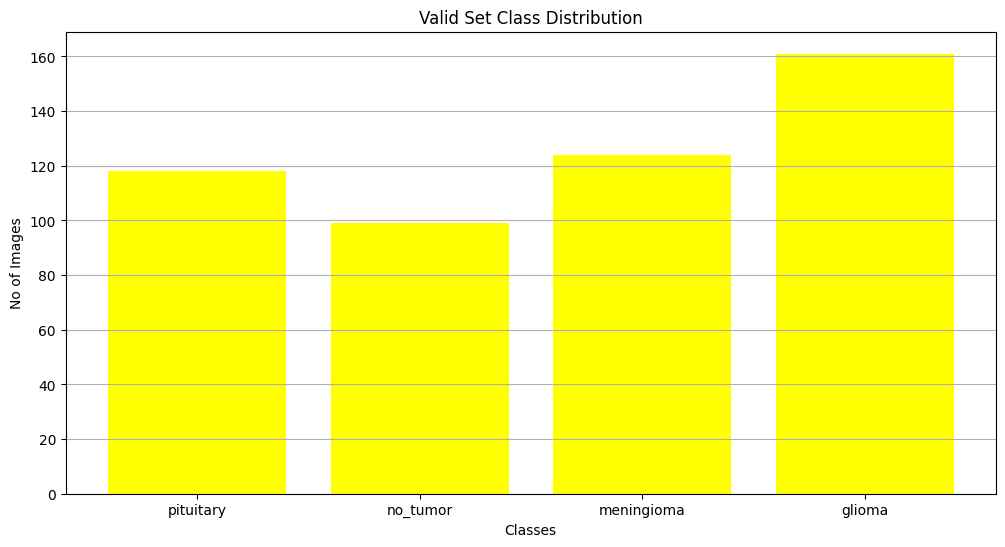

In [10]:
list3=[]
count=[]
for i in os.listdir(valid_path):
    if(os.path.isdir(os.path.join(valid_path,i))):
        list3.append(i)
        count.append(len(os.listdir(os.path.join(valid_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list3,count,color="yellow")
plt.title("Valid Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 4. Image Resolution Consistency Bar Graph

##### i. Training set


Unique Image Resolutions:
(640, 640): 1695 images


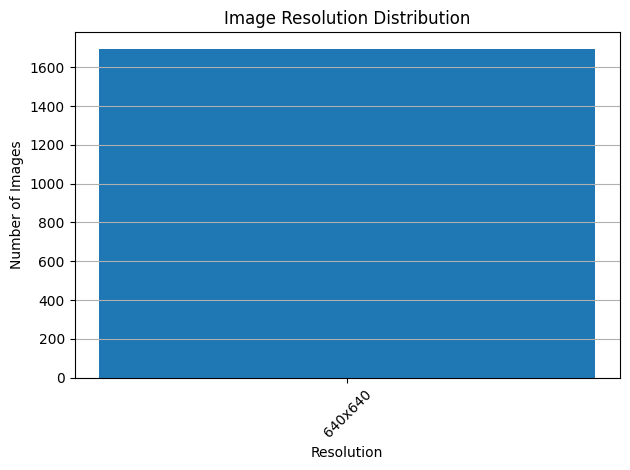

In [11]:
check_image_resolutions(train_path)

##### ii. Testing set


Unique Image Resolutions:
(640, 640): 246 images


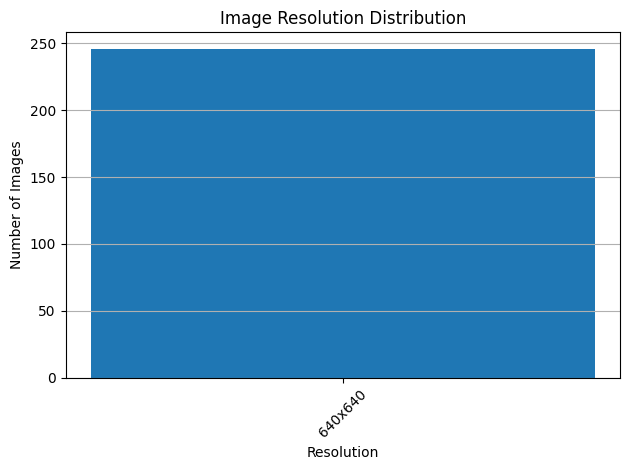

In [12]:
check_image_resolutions(test_path)

#### 3. Brightness distribution Histogram

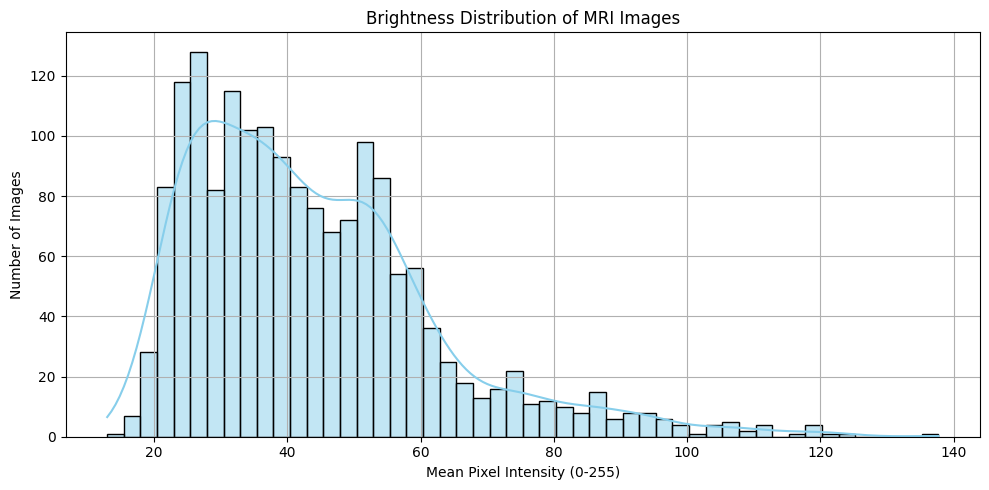

In [13]:
def brightness_dist(data_path):
    brightness_list = []
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    for i in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, i)):
            for j in os.listdir(os.path.join(data_path, i)):
                img = os.path.join(data_path, i, j)
                image = Image.open(img).convert("L")
                img_pix_list = np.array(image)
                mean_brightness = np.mean(img_pix_list)
                brightness_list.append(mean_brightness)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(brightness_list, bins=50, color='skyblue', kde=True)
    plt.title("Brightness Distribution of MRI Images")
    plt.xlabel("Mean Pixel Intensity (0-255)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
brightness_dist(train_path)

#### 4. Pixel Intensity Histogram

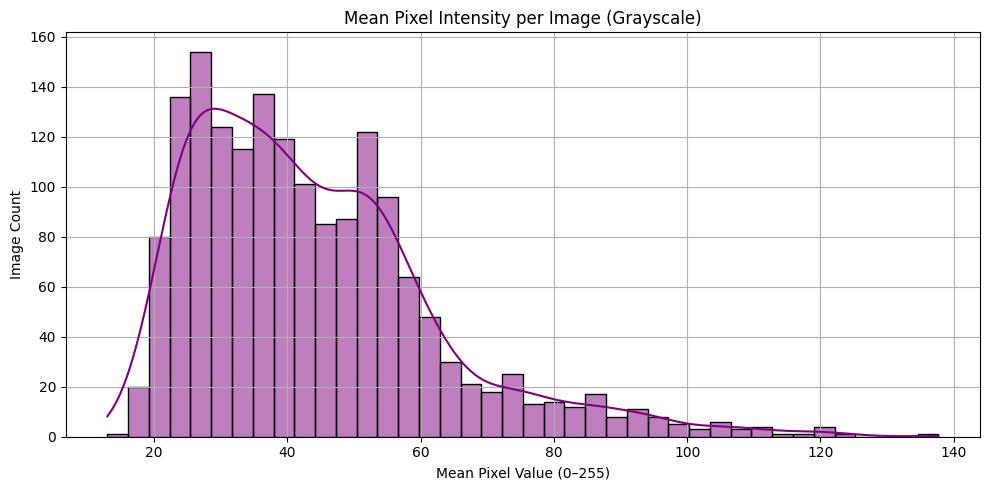

In [14]:
def pixel_intensity_per_image(data_path):
    mean_pixel_values = []

    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        if not os.path.isdir(class_path): continue

        for image_file in os.listdir(class_path):
            try:
                image_path = os.path.join(class_path, image_file)
                img = Image.open(image_path).convert("L")
                img_arr = np.array(img)
                mean_pixel_values.append(np.mean(img_arr))
            except:
                continue

    plt.figure(figsize=(10, 5))
    sns.histplot(mean_pixel_values, bins=40, kde=True, color="purple")
    plt.title("Mean Pixel Intensity per Image (Grayscale)")
    plt.xlabel("Mean Pixel Value (0–255)")
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
pixel_intensity_per_image(train_path)

### Bivariant Analysis

#### 5. Class Count across Folders

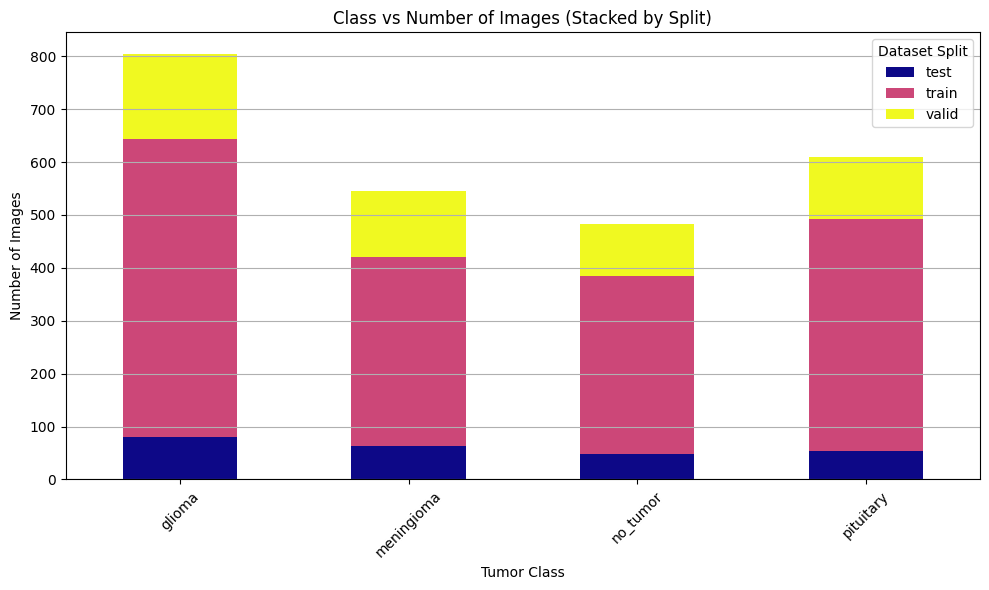

In [15]:
data = []

# Loop through splits and classes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path): continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path): continue  
        num_images = len(os.listdir(cls_path))
        data.append({"Class": cls, "Split": split, "ImageCount": num_images})

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot to wide format for stacked bar
pivot_df = df.pivot(index="Class", columns="Split", values="ImageCount").fillna(0)

# Plot stacked bar
pivot_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap='plasma')
plt.title("Class vs Number of Images (Stacked by Split)")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

#### 6. Class VS Pixel Intensity Boxplot

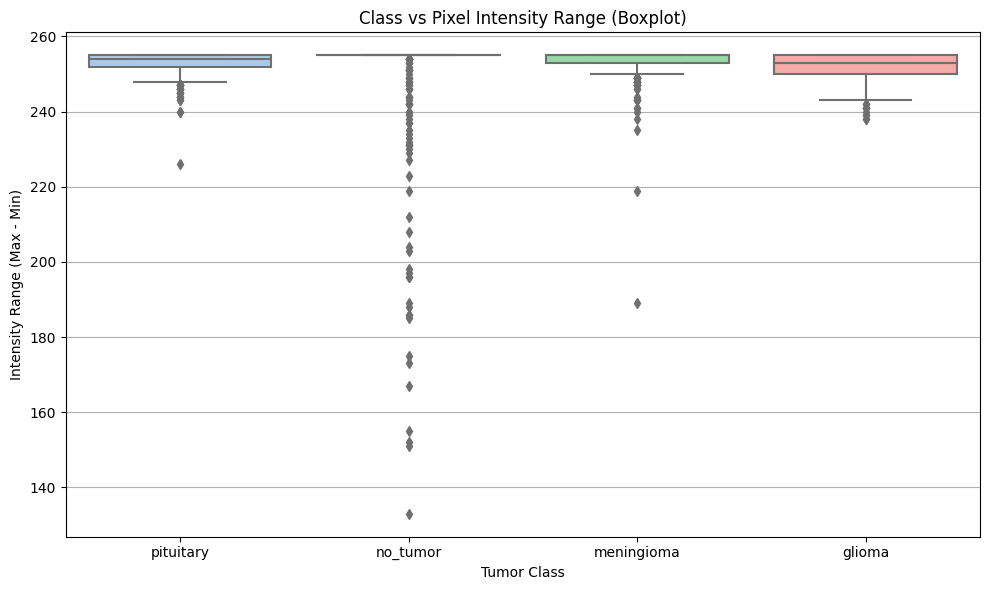

In [16]:
# Build DataFrame with intensity range
data = []
for i in os.listdir(train_path):
    if (os.path.isdir(os.path.join(train_path,i))):
        for j in os.listdir(os.path.join(train_path,i)):
            img=os.path.join(train_path,i,j)
            image=Image.open(img).convert("L")
            img_list=np.array(image)
            intensity_range=np.max(img_list)-np.min(img_list)
            data.append({"class": i, "intensity_range": intensity_range})

df = pd.DataFrame(data)

# Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='intensity_range', data=df, palette='pastel')
plt.title("Class vs Pixel Intensity Range (Boxplot)")
plt.ylabel("Intensity Range (Max - Min)")
plt.xlabel("Tumor Class")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 7. Class VS brigthness historgram

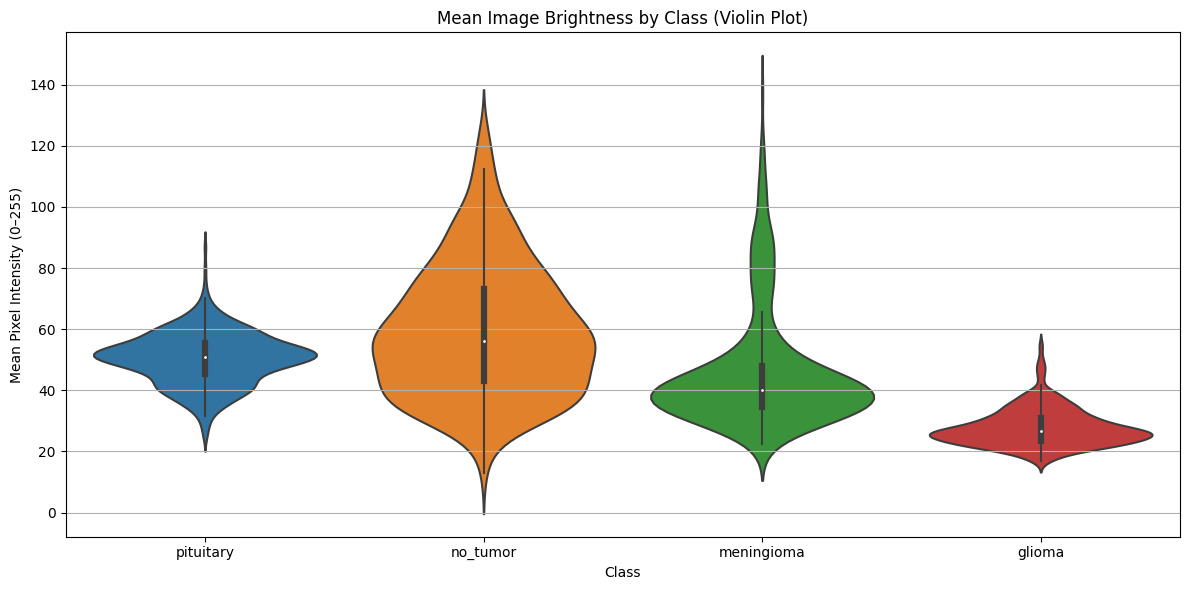

In [17]:
def class_vs_brightness_violin(data_path):
    records = []
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Collect brightness data with class labels
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert("L")
                    img_pix = np.array(image)
                    mean_brightness = np.mean(img_pix)
                    records.append({"Class": class_name, "Brightness": mean_brightness})
                except Exception as e:
                    continue

    # Create DataFrame for plotting
    df = pd.DataFrame(records)

    # Violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Class", y="Brightness", data=df, inner="box", scale="width")
    plt.title("Mean Image Brightness by Class (Violin Plot)")
    plt.xlabel("Class")
    plt.ylabel("Mean Pixel Intensity (0–255)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
class_vs_brightness_violin(train_path)

#### 8. Feature Correlation Heatmap

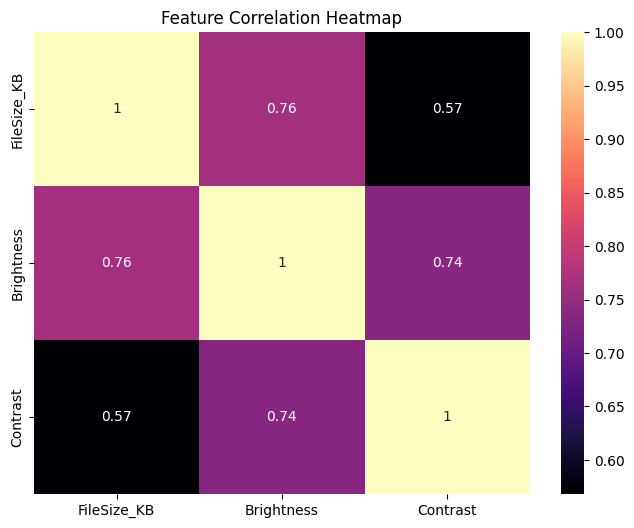

In [18]:
def build_feature_df(data_path):
    records = []
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert('L')
                    img_array = np.array(image)
                    width, height = image.size
                    file_size_kb = os.path.getsize(img_path)/1024
                    mean_brightness = np.mean(img_array)
                    contrast = np.std(img_array)
                    records.append({
                        'Class': class_name,
                        'Width': width,
                        'Height': height,
                        'FileSize_KB': file_size_kb,
                        'Brightness': mean_brightness,
                        'Contrast': contrast
                    })
                except Exception:
                    continue
    return pd.DataFrame(records)

# Build DataFrame from all images in the dataset
df = build_feature_df(train_path)
# Compute and plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['FileSize_KB', 'Brightness', 'Contrast']].corr(), annot=True , cmap="magma")
plt.title("Feature Correlation Heatmap")
plt.show()


# **2. Data Preprocessing**

## 1.Normalizing Pixel Values

In [19]:
def normalize_images(path):
    normalized_images = []
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                try:
                    with Image.open(img_path).convert("L") as img:
                        img_array = np.array(img)
                        normalized_arr = img_array.astype("float32") / 255.0
                        normalized_images.append(normalized_arr) 
                except Exception as e:
                    print(f"Failed to process {img_path}: {e}")

normalize_images(train_path)
normalize_images(test_path)
normalize_images(valid_path)

## 2. Resizing Images